## This notebook demonstrates how to perform bulk inference of [`openai/gpt-oss-120b`](https://huggingface.co/`openai/gpt-oss-120b`) on the [Tracto.ai](https://tracto.ai/) platform.

To run this notebook please use `cr.eu-north1.nebius.cloud/e00faee7vas5hpsh3s/solutions/examples:v16` in jupyter kernel.

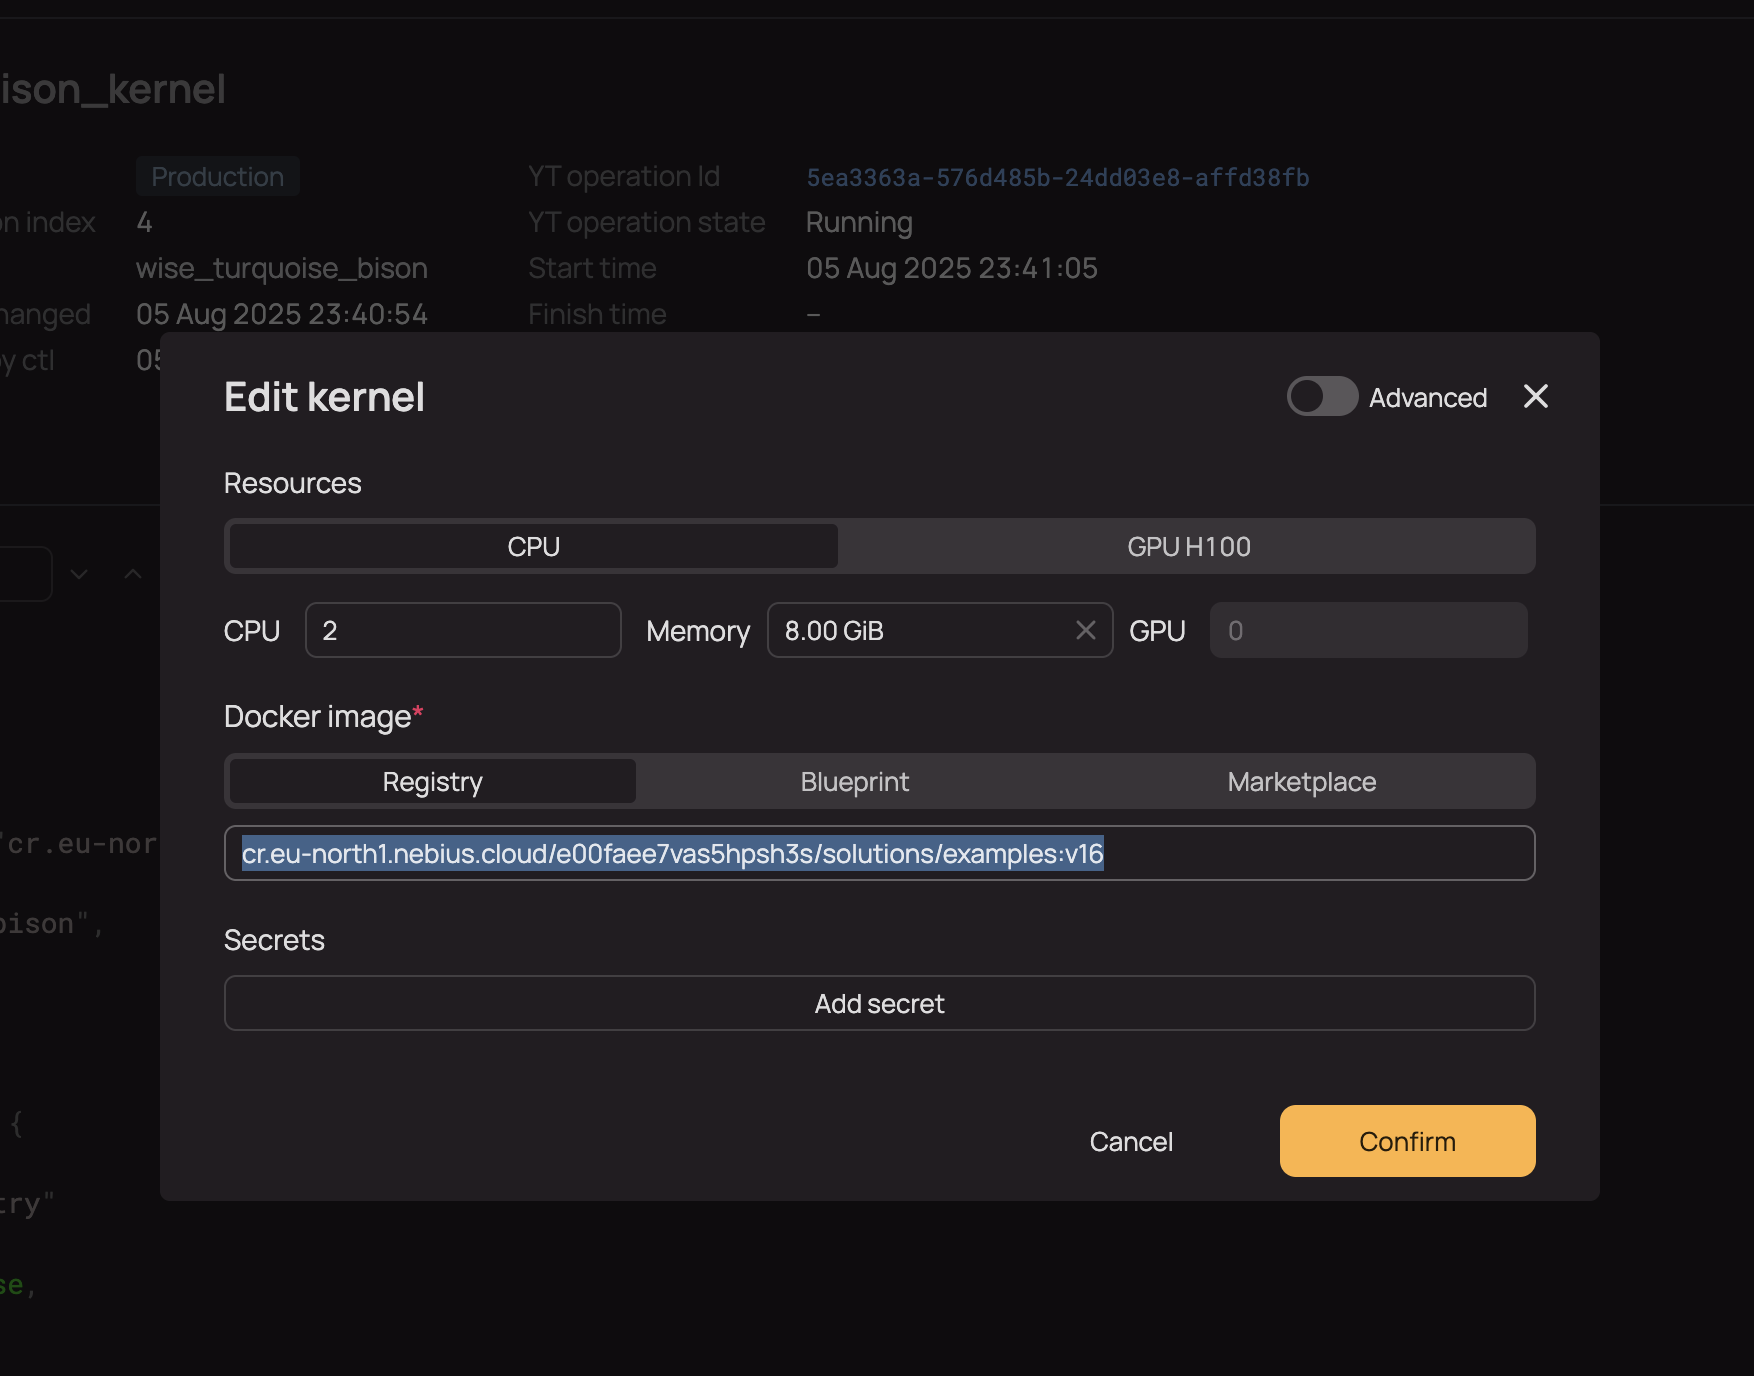

Tracto is perfect for offline batch inference:

* Easy scaling - just change the `job_count` parameter.
* Fault tolerance out of the box - if a job crashes, it gets restarted automatically. No need to handle GPU failures or infrastructure issues - Tracto takes care of it.
* Full Tracto integration - save results directly to the distributed file system and process them further on the platform.

In [1]:
# configure environment to run this notebooks
import uuid
import yt.wrapper as yt

username = yt.get_user_name()
if yt.exists(f"//sys/users/{username}/@user_info/home_path"):
    # prepare working directory on distributed file system
    user_info = yt.get(f"//sys/users/{yt.get_user_name()}/@user_info")
    homedir = user_info["home_path"]
    # find avaliable vm presets
    cpu_pool_trees = [pool_tree for pool_tree in user_info["available_pool_trees"] if pool_tree.endswith("cpu")] or ["default"]
    h100_pool_trees = [pool_tree for pool_tree in user_info["available_pool_trees"] if pool_tree.endswith("h100")]
    h100_8_pool_trees = [pool_tree for pool_tree in user_info["available_pool_trees"] if pool_tree.endswith("h100-8")]
    h200_pool_trees = [pool_tree for pool_tree in user_info["available_pool_trees"] if pool_tree.endswith("h200")]
    h200_8_pool_trees = [pool_tree for pool_tree in user_info["available_pool_trees"] if pool_tree.endswith("h200-8")]
    workdir = f"{homedir}/tmp/demo_workdir/{uuid.uuid4().hex}"
else:
    cpu_pool_trees = ["default"]
    h100_pool_trees = ["gpu_h100"]
    h100_8_pool_trees = ["gpu_h100"]
    h200_pool_trees = ["gpu_h200"]
    h200_8_pool_trees = ["gpu_h200"]
    workdir = f"//tmp/examples/{uuid.uuid4().hex}"

yt.create("map_node", workdir, recursive=True, ignore_existing=True)
print("Current working directory:", workdir)

Current working directory: //home/wise_turquoise_bison/tmp/demo_workdir/1417b275c05446cdb0a48ee874e08cfd


Prepare data for inference as a table.

In [3]:
from datasets import load_dataset

dataset = load_dataset("Rapidata/Other-Animals-10")

table_path = f"{workdir}/questions"
yt.create("table", table_path, force=True)

questions = [
    {"question": f"Can a {animal} fly? If it can't - how can we help it take off?"}
    for animal in set(dataset["train"].features["label"].int2str(dataset["train"]["label"]))
]

yt.write_table(table_path, questions)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103 [00:00<?, ? examples/s]

Run bulk inference of `openai/gpt-oss-120b`.

In [5]:
from typing import Iterable
import logging
import sys
import random

yt.config["pickling"]["safe_stream_mode"] = False


result_path = f"{workdir}/result"


@yt.aggregator
def bulk_inference(records: Iterable[dict[str, str]]) -> Iterable[dict[str, str]]:
    from vllm import LLM, SamplingParams

    llm = LLM(
        model="openai/gpt-oss-120b",
        trust_remote_code=True,
        gpu_memory_utilization=0.95,
        max_model_len=32768,
    )
    sampling_params = SamplingParams(
        temperature=0.6,
        top_p=0.9,
        max_tokens=8000,
    )

    conversations = [
        [
            {
                "role": "user",
                "content": record["question"],
            },
        ]
        for record in records
    ]
    outputs = llm.chat(
        messages=conversations,
        sampling_params=sampling_params,
    )
    for prompt, output in zip(conversations, outputs):
        yield {
            "prompt": prompt,
            "text": output.outputs[0].text,
        }


yt.run_map(
    bulk_inference,
    table_path,
    result_path,
    job_count=2,
    spec={
        "pool_trees": h100_pool_trees,
        "mapper": {
            "gpu_limit": 1,
            "memory_limit": 64 * 1024 * 1024 * 1024,
            "cpu_limit": 10,
            "tmpfs_path": ".",
            "tmpfs_size": 256 * 1024 * 1024 * 1024,
            "environment": {
                # improtant for vllm v1
                "VLLM_WORKER_MULTIPROC_METHOD": "spawn",
            },
        },
    },
)

2025-08-05 22:59:33,073	INFO	Operation started: https://playground.tracto.ai/playground/operations/d1d9e356-827a138d-24dd03e8-f7687d45/details


2025-08-05 22:59:33,136	INFO	( 0 min) operation d1d9e356-827a138d-24dd03e8-f7687d45 starting


2025-08-05 22:59:33,699	INFO	( 0 min) operation d1d9e356-827a138d-24dd03e8-f7687d45 initializing


2025-08-05 22:59:34,903	INFO	( 0 min) Unrecognized spec: {'enable_partitioned_data_balancing': false, 'mapper': {'title': 'bulk_inference'}}


2025-08-05 22:59:36,806	INFO	( 0 min) operation d1d9e356-827a138d-24dd03e8-f7687d45: running=0     completed=0     pending=2     failed=0     aborted=0     lost=0     total=2     blocked=0    


2025-08-05 22:59:43,773	INFO	( 0 min) operation d1d9e356-827a138d-24dd03e8-f7687d45: running=2     completed=0     pending=0     failed=0     aborted=0     lost=0     total=2     blocked=0    


2025-08-05 23:05:37,026	INFO	( 6 min) operation d1d9e356-827a138d-24dd03e8-f7687d45 completed


2025-08-05 23:05:37,118	INFO	( 6 min) Alerts: {'unused_tmpfs_space': {'code': 1, 'message': 'Operation has jobs that use tmpfs inefficiently; consider specifying tmpfs size closer to actual usage', 'attributes': {'pid': 1, 'tid': 12876502265127788752, 'thread': 'Controller:0', 'fid': 18445718247892935676, 'host': 'ca-1.controller-agents.nebius-playground.svc.kyt.k8s.nebius.yt', 'datetime': '2025-08-05T23:05:33.623818Z', 'trace_id': 'ad3c6b4c-4d7bacaf-91950b5-980120ae', 'span_id': 8225188680732546562}, 'inner_errors': [{'code': 1, 'message': 'Jobs of type "map" use less than 80.0% of requested tmpfs size in volume "."', 'attributes': {'pid': 1, 'tid': 12876502265127788752, 'thread': 'Controller:0', 'fid': 18445718247892935676, 'host': 'ca-1.controller-agents.nebius-playground.svc.kyt.k8s.nebius.yt', 'datetime': '2025-08-05T23:05:33.623815Z', 'trace_id': 'ad3c6b4c-4d7bacaf-91950b5-980120ae', 'span_id': 8225188680732546562, 'max_used_tmpfs_size': 141510438912, 'tmpfs_size': 274877906944}}

In [6]:
for record in yt.read_table(result_path):
    print(f"Q: {record['prompt']}")
    print(f"A: {record['text']}")

Q: [{'role': 'user', 'content': "Can a fox fly? If it can't - how can we help it take off?"}]
A: analysisThe user asks: "Can a fox (presumably a real animal) fly? If it can't - how can we help it take off?" This is a whimsical question. We need to answer: No, foxes cannot fly; they are mammals without wings. Then discuss ways to help a fox "take off" metaphorically: maybe using a glider, parachute, or assist with a balloon, or just let it run. Could also discuss using technology like a jetpack, or a drone harness. Also discuss ethical considerations, animal welfare, legal issues. Provide safe, humane suggestions: do not force unnatural behavior, let fox be in its natural environment. If it's a metaphor for helping a fox overcome obstacles, we can talk about habitat restoration, conservation, etc.

We should be thorough, include scientific explanation of why foxes can't fly, anatomy, physics. Then discuss alternative ways to help a fox "take off": e.g., building a safe environment, help